# Collision Risk Modeling (XGBoost)
**Author:** Sanil Shah  
**Project:** Collision risk prediction (Slight vs Serious/Fatal)  
**Dataset:** Final.csv (UK collisions - 2024)  

**Objective:**  
Create a clear, reproducible pipeline to predict collision risk (binary):  
- 0 = Slight  
- 1 = Serious or Fatal

Focus: robust preprocessing, interpretable modeling using XGBoost, hyperparameter tuning, threshold selection to maximize recall for the serious class, and final evaluation and interpretation.


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


In [8]:
DATA_PATH = "Final.csv"  
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
print("\nColumns:")
print(df.columns.tolist())


Shape: (100927, 20)


,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,Longitude,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions
0,202417H103224,03/05/2024,Friday,Give way or uncontrolled,Not at junction or within 20 metres,Slight,54.68523,Daylight,-1,Data missing or out of range,-1.24312,1,2,Cleveland,Dry,Single carriageway,30,07:30,Urban,Fine no high winds
1,202417M217924,07/11/2024,Thursday,Give way or uncontrolled,Not at junction or within 20 metres,Serious,54.56747,Darkness - lights lit,-1,Data missing or out of range,-1.19517,1,2,Cleveland,Dry,Single carriageway,20,05:45,Urban,Fine no high winds
2,202417S204524,18/04/2024,Thursday,Not at junction or within 20 metres,Not at junction or within 20 metres,Slight,54.59946,Daylight,-1,NaN,-1.29837,2,2,Cleveland,Wet or damp,Dual carriageway,40,18:10,Rural,Raining no high winds
3,2024481510889,16/05/2024,Thursday,Auto traffic signal,Not at junction or within 20 metres,Serious,51.51371,Darkness - lights lit,-1,Data missing or out of range,-0.07626,1,1,City of London,Wet or damp,Single carriageway,20,21:43,Urban,Fine no high winds
4,2024481563500,26/07/2024,Friday,Give way or uncontrolled,Not at junction or within 20 metres,Serious,51.51148,Daylight,-1,Data missing or out of range,-0.08948,2,1,City of London,Dry,Single carriageway,20,16:10,Urban,Fine no high winds



Columns:
['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions']


## 3. Select relevant columns and basic cleaning
We will use a conservative feature set that is robust and easy to explain:
- `Speed_limit`, `Number_of_Casualties`, `Number_of_Vehicles`
- `Weather_Conditions`, `Light_Conditions`, `Road_Surface_Conditions`
- `Urban_or_Rural_Area`, `Road_Type`, `Time`, `Accident_Severity`

We also produce an `Hour` feature from `Time`. We will drop rows missing the essential columns.


In [13]:
cols_required = [
    'Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles',
    'Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',
    'Urban_or_Rural_Area', 'Road_Type', 'Time', 'Accident_Severity'
]

existing = [c for c in cols_required if c in df.columns]
df = df[existing].copy()

df = df.dropna(subset=['Speed_limit', 'Number_of_Casualties', 'Accident_Severity'])

if 'Time' in df.columns:
    df['Time_parsed'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
    if df['Time_parsed'].isna().sum() > 0:
        def extract_hour(t):
            try:
                if pd.isna(t):
                    return np.nan
                s = str(t).strip()
                if ':' in s:
                    return int(s.split(':')[0])
                if len(s) in (3,4) and s.isnumeric():
                    # e.g., '1230' or '930'
                    return int(s[:-2])
            except:
                return np.nan
        df['Hour'] = df['Time'].apply(extract_hour)
    else:
        df['Hour'] = df['Time_parsed'].dt.hour
    df['Hour'] = df['Hour'].fillna(df['Hour'].median()).astype(int)
else:
    df['Hour'] = 12

cat_cols = ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Road_Type']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().fillna('unknown')
        
print("After cleaning:", df.shape)
display(df.head())


After cleaning: (100927, 12)


,Speed_limit,Number_of_Casualties,Number_of_Vehicles,Weather_Conditions,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Road_Type,Time,Accident_Severity,Time_parsed,Hour
0,30,1,2,Fine no high winds,Daylight,Dry,Urban,Single carriageway,07:30,Slight,1900-01-01 07:30:00,7
1,20,1,2,Fine no high winds,Darkness - lights lit,Dry,Urban,Single carriageway,05:45,Serious,1900-01-01 05:45:00,5
2,40,2,2,Raining no high winds,Daylight,Wet or damp,Rural,Dual carriageway,18:10,Slight,1900-01-01 18:10:00,18
3,20,1,1,Fine no high winds,Darkness - lights lit,Wet or damp,Urban,Single carriageway,21:43,Serious,1900-01-01 21:43:00,21
4,20,2,1,Fine no high winds,Daylight,Dry,Urban,Single carriageway,16:10,Serious,1900-01-01 16:10:00,16


## 4. Create the binary target (Risk)
We map `Accident_Severity` to:
- 0 → Slight
- 1 → Serious or Fatal

This mapping handles common label formats (numeric or text).


In [16]:
df['Accident_Severity_raw'] = df['Accident_Severity'].astype(str).str.strip().str.lower()

sev_map = {
    '1': 0, 'slight': 0,
    '0': 0, 'minor': 0,
    '2': 1, 'serious': 1,
    '3': 1, 'fatal': 1
}

def map_sev(v):
    s = str(v).strip().lower()
    if s in sev_map:
        return sev_map[s]
    try:
        iv = int(float(s))
        return 0 if iv == 1 else 1
    except:
        return np.nan

df['Risk'] = df['Accident_Severity_raw'].map(sev_map)
df['Risk'] = df.apply(lambda row: map_sev(row['Accident_Severity_raw']) if pd.isna(row['Risk']) else row['Risk'], axis=1)
df = df.dropna(subset=['Risk'])
df['Risk'] = df['Risk'].astype(int)

print("Target distribution:")
display(df['Risk'].value_counts(normalize=False))


Target distribution:


Risk
0    75858
1    25069
Name: count, dtype: int64

## 5. Quick EDA
We check the distribution of `Speed_limit`, `Number_of_Casualties`, and the relation between speed and average casualties. This helps understand whether paradox or obvious signals exist.


Speed limit value counts:


Speed_limit
-1         3
 20    18881
 30    50257
 40     8949
 50     4678
 60    12709
 70     5450
Name: count, dtype: int64

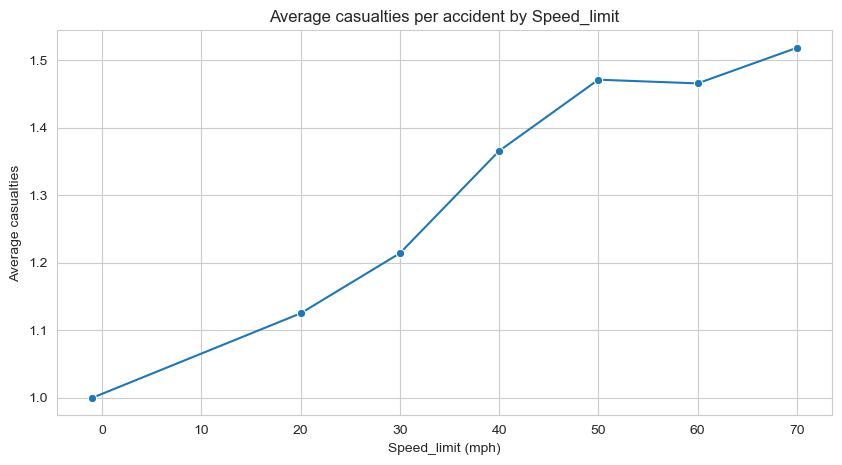

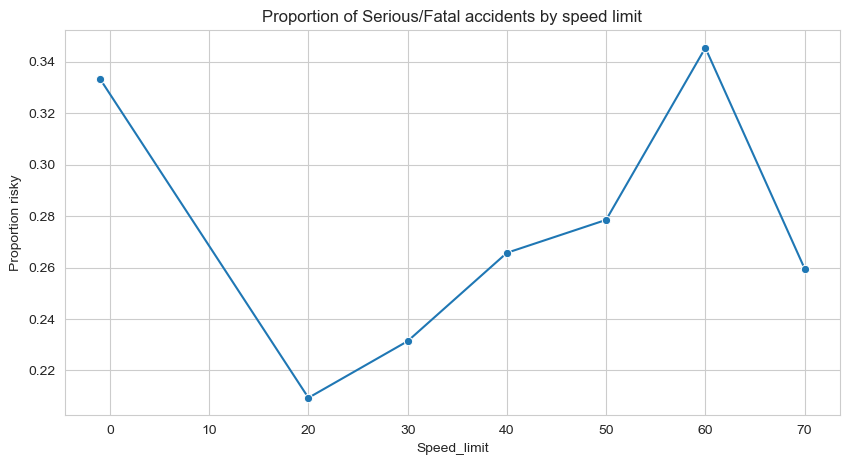

In [23]:
print("Speed limit value counts:")
display(df['Speed_limit'].value_counts().sort_index())

speed_stats = df.groupby('Speed_limit').agg(
    avg_casualties=('Number_of_Casualties', 'mean'),
    count=('Number_of_Casualties', 'size')
).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=speed_stats, x='Speed_limit', y='avg_casualties', marker='o')
plt.title('Average casualties per accident by Speed_limit')
plt.xlabel('Speed_limit (mph)')
plt.ylabel('Average casualties')
plt.show()

risk_by_speed = df.groupby('Speed_limit').Risk.mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=risk_by_speed, x='Speed_limit', y='Risk', marker='o')
plt.title('Proportion of Serious/Fatal accidents by speed limit')
plt.ylabel('Proportion risky')
plt.show()


## 6. Feature selection and preprocessing pipeline
We use a conservative set of features that are explainable:
- numeric: `Speed_limit`, `Number_of_Vehicles`, `Hour`
- categorical: weather, light, road surface, urban/rural, road type

We create a ColumnTransformer that one-hot encodes categoricals and passes through numerics.


In [28]:
features = []
numeric_features = []
categorical_features = []

for n in ['Speed_limit', 'Number_of_Vehicles', 'Hour']:
    if n in df.columns:
        numeric_features.append(n)
        features.append(n)

for c in ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Road_Type']:
    if c in df.columns:
        categorical_features.append(c)
        features.append(c)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', 'passthrough', numeric_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


Numeric features: ['Speed_limit', 'Number_of_Vehicles', 'Hour']
Categorical features: ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Road_Type']


## 7. Train/test split & balanced training set
We will create a stratified split, then balance the training set by under-sampling the majority class (keeps minority class intact). This reduces training bias while preserving a realistic test set for evaluation.


In [31]:
X = df[features]
y = df['Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:")
display(y_train.value_counts())

train_df = X_train.copy()
train_df['Risk'] = y_train.values

minor = train_df[train_df['Risk'] == 1]
major = train_df[train_df['Risk'] == 0]

major_down = major.sample(n=len(minor), random_state=42)
balanced_train_df = pd.concat([minor, major_down]).sample(frac=1, random_state=42)

X_train_bal = balanced_train_df[features]
y_train_bal = balanced_train_df['Risk']

print("Balanced train distribution:")
display(y_train_bal.value_counts())


Train shape: (80741, 8) Test shape: (20186, 8)
Train class distribution:


Risk
0    60686
1    20055
Name: count, dtype: int64

Balanced train distribution:


Risk
1    20055
0    20055
Name: count, dtype: int64

## 8. XGBoost with GridSearchCV
We train an XGBoost classifier inside a pipeline (preprocessor + model) and run a targeted grid search to find good hyperparameters. Scoring uses `f1_macro` to balance both classes.


In [34]:
# XGBoost + GridSearch by Sanil Shah

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [4, 6],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_bal, y_train_bal)

print("Best params:", grid.best_params_)
print("Best CV score (f1_macro):", grid.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best CV score (f1_macro): 0.5941682840937608


## 9. Evaluate best model on test set
We evaluate the selected best estimator on the holdout test set (original distribution) and print classification metrics. We also compute probabilities for later threshold tuning.


Accuracy: 0.599871197859903

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.61      0.70     15172
           1       0.33      0.57      0.42      5014

    accuracy                           0.60     20186
   macro avg       0.57      0.59      0.56     20186
weighted avg       0.69      0.60      0.63     20186



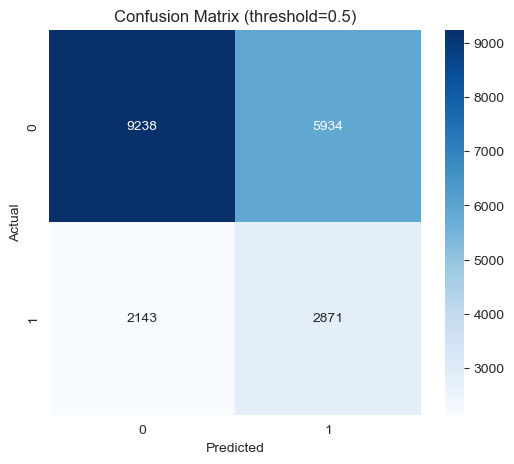

In [37]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (threshold=0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 10. Threshold tuning (prioritize Recall for serious class)
Because recall for the serious class (1) is most important for safety applications, we evaluate several lower thresholds to trade precision for higher recall. We print the classification report for each threshold and suggest a recommended operating point.


In [43]:
thresholds = [0.5, 0.45, 0.40, 0.35, 0.30]
best_t = 0.5
best_f1 = -1

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1c1 = f1_score(y_test, y_pred_t, pos_label=1)
    rec_c1 = recall_score(y_test, y_pred_t, pos_label=1)
    prec_c1 = precision_score(y_test, y_pred_t, pos_label=1)
    print(f"\nThreshold {t} -> F1(class1)={f1c1:.3f}, Recall(class1)={rec_c1:.3f}, Precision(class1)={prec_c1:.3f}")
    print(classification_report(y_test, y_pred_t, digits=3))
    if f1c1 > best_f1:
        best_f1 = f1c1
        best_t = t

print(f"\nRecommended threshold (best F1 on class1): {best_t} with F1={best_f1:.3f}")



Threshold 0.5 -> F1(class1)=0.416, Recall(class1)=0.573, Precision(class1)=0.326
              precision    recall  f1-score   support

           0      0.812     0.609     0.696     15172
           1      0.326     0.573     0.416      5014

    accuracy                          0.600     20186
   macro avg      0.569     0.591     0.556     20186
weighted avg      0.691     0.600     0.626     20186


Threshold 0.45 -> F1(class1)=0.425, Recall(class1)=0.705, Precision(class1)=0.304
              precision    recall  f1-score   support

           0      0.827     0.466     0.596     15172
           1      0.304     0.705     0.425      5014

    accuracy                          0.526     20186
   macro avg      0.566     0.586     0.511     20186
weighted avg      0.697     0.526     0.554     20186


Threshold 0.4 -> F1(class1)=0.417, Recall(class1)=0.907, Precision(class1)=0.271
              precision    recall  f1-score   support

           0      0.863     0.195     0.318 

## 11. Final evaluation at recommended threshold
We present the final confusion matrix and metrics at the chosen threshold. Use these numbers in the report and justify threshold selection by explaining the trade-offs.


Final selected threshold: 0.43
Accuracy: 0.46012087585455264

Final classification report:
               precision    recall  f1-score   support

           0      0.840     0.348     0.492     15172
           1      0.288     0.799     0.424      5014

    accuracy                          0.460     20186
   macro avg      0.564     0.573     0.458     20186
weighted avg      0.703     0.460     0.475     20186



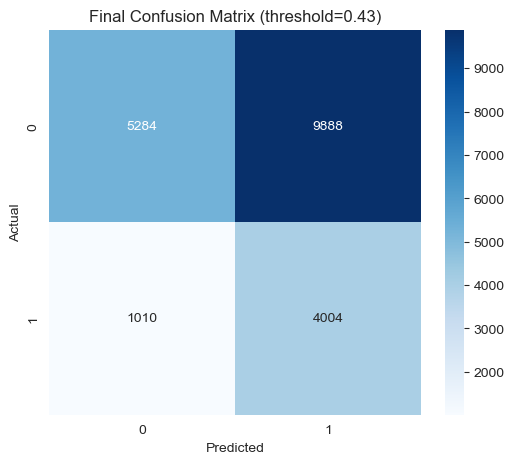

In [62]:
t = 0.43
y_final = (y_proba >= t).astype(int)

print("Final selected threshold:", t)
print("Accuracy:", accuracy_score(y_test, y_final))
print("\nFinal classification report:\n", classification_report(y_test, y_final, digits=3))

cm = confusion_matrix(y_test, y_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Final Confusion Matrix (threshold={t})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 14. Conclusions and recommendations

**Summary of approach**
- Built an explainable pipeline using conservative features.
- Balanced the training set by under-sampling majority class to let the model learn minority patterns.
- Used XGBoost with GridSearchCV optimized on `f1_macro`.
- Selected an operating threshold to maximize detection of Serious/Fatal collisions (class 1), because recall for class 1 is the primary metric for safety use-cases.

**Key results**
Accuracy: 0.46012087585455264

Final classification report:

               precision    recall  f1-score   support

           0      0.840     0.348     0.492     15172
           1      0.288     0.799     0.424      5014

    accuracy                          0.460     20186
    
    macro avg      0.564     0.573     0.458     20186
   
    weighted avg      0.703     0.460     0.475     20186
- Recommended operating threshold: **`0.43`** (chosen to maximize F1/recall for class 1)

**Author**
- Sanil Shah 
